<a href="https://colab.research.google.com/github/Josh-Rogers-Sr/Regression-Analysis/blob/main/Josh_Rogers_MSDA_Capstone_Car_Prices_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import shapiro
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as ols
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [2]:
df = pd.read_csv('Car_Prices_Final.csv',usecols=['year','make','body','transmission','odometer','color','Price_Diff', 'condition'])

print(df.head())
print(df.shape)
print(df.info())
print(df.describe())

categorical_vars = ['make', 'body', 'transmission', 'color', 'condition']
continuous_vars = ['year', 'odometer', 'Price_Diff']

   year   make   body transmission  condition  odometer  color  Price_Diff
0  2015    Kia    SUV    automatic        5.0   16639.0  white        1000
1  2015    Kia    SUV    automatic        5.0    9393.0  white         700
2  2014    BMW  Sedan    automatic       45.0    1331.0   gray       -1900
3  2015  Volvo  Sedan    automatic       41.0   14282.0  white         250
4  2014    BMW  Sedan    automatic       43.0    2641.0   gray        1000
(25000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          25000 non-null  int64  
 1   make          24882 non-null  object 
 2   body          24158 non-null  object 
 3   transmission  22184 non-null  object 
 4   condition     18198 non-null  float64
 5   odometer      24973 non-null  float64
 6   color         24928 non-null  object 
 7   Price_Diff    25000 non-null  int64  
d

In [3]:
# Create a new object that omits null rows
df_filtered = df.dropna()

summary_stats = df_filtered.describe()[['year', 'odometer', 'Price_Diff']]
print(summary_stats)
print(df_filtered.shape)

               year       odometer    Price_Diff
count  15924.000000   15924.000000  15924.000000
mean    2009.456795   74763.476011   -361.613853
std        3.406214   53237.450465   1979.930379
min     1991.000000       1.000000 -37900.000000
25%     2007.000000   32814.750000  -1150.000000
50%     2010.000000   67226.500000   -200.000000
75%     2012.000000  107469.000000    650.000000
max     2015.000000  999999.000000  35300.000000
(15924, 8)


In [4]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for each numerical column
Q1 = df_filtered[['year', 'odometer', 'Price_Diff']].quantile(0.25)
Q3 = df_filtered[['year', 'odometer', 'Price_Diff']].quantile(0.75)

# Calculate the IQR for each numerical column
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers for each numerical column
outliers = ((df_filtered[['year', 'odometer', 'Price_Diff']] < lower_bound) | (df_filtered[['year', 'odometer', 'Price_Diff']] > upper_bound))

# Count the number of outliers for each column
outlier_counts = outliers.sum()
print("Outlier Counts:")
print(outlier_counts)

Outlier Counts:
year          121
odometer      148
Price_Diff    842
dtype: int64


In [ ]:
df_filtered = df_filtered[~outliers.any(axis=1)]

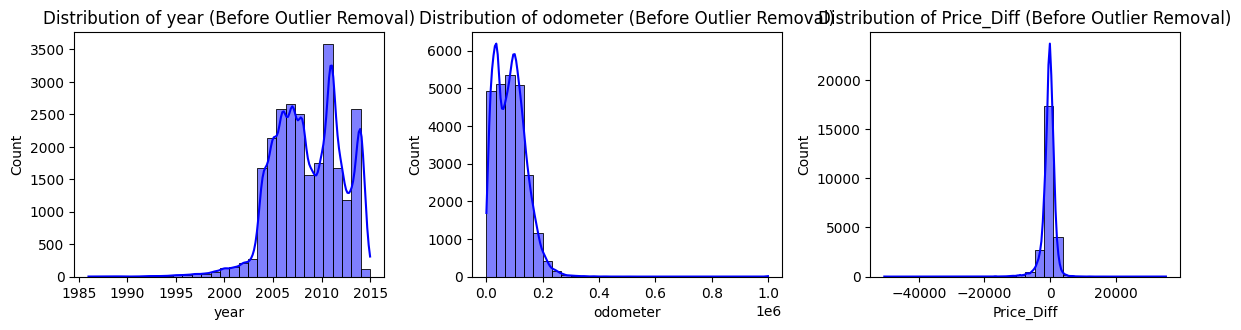

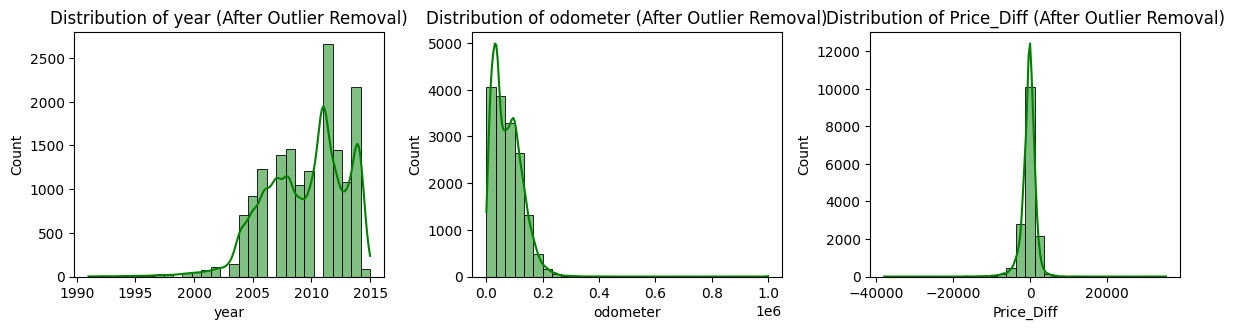

In [5]:
# Plotting distribution of key variables before outlier removal
plt.figure(figsize=(12, 6))

# Plot histograms for 'year', 'odometer', and 'Price_Diff' before removing outliers
for i, col in enumerate(continuous_vars, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col} (Before Outlier Removal)')

plt.tight_layout()
plt.show()

# Plotting distribution of key variables after outlier removal
plt.figure(figsize=(12, 6))

# Plot histograms for 'year', 'odometer', and 'Price_Diff' after removing outliers
for i, col in enumerate(continuous_vars, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_filtered[col], kde=True, bins=30, color='green')
    plt.title(f'Distribution of {col} (After Outlier Removal)')

plt.tight_layout()
plt.show()

In [6]:
df_filtered = df_filtered.copy()

# Fill missing values
df_filtered.loc[:, 'condition'] = df_filtered['condition'].fillna('Unknown')

# Create 'condition_category'
df_filtered.loc[:, 'condition_category'] = np.where(
    df_filtered['condition'] == 'Unknown', 'Unknown',
    np.where(df_filtered['condition'] <= 15, 'Poor',
             np.where(df_filtered['condition'] <= 30, 'Fair',
                      np.where(df_filtered['condition'] <= 40, 'Good', 'Excellent'))))

print(df_filtered[['condition', 'condition_category']].head())

   condition condition_category
0        5.0               Poor
1        5.0               Poor
2       45.0          Excellent
3       41.0          Excellent
4       43.0          Excellent


In [8]:
# Apply one-hot encoding to categorical variables (make, color, etc.)
df_ohe = pd.get_dummies(df_filtered[categorical_vars], drop_first=True, dtype=int)

# Concatenate numerical columns
df_ohe = pd.concat([df_ohe, df_filtered[['year', 'odometer', 'Price_Diff']]], axis=1)

# Check the resulting dataframe
print(df_ohe.head())
print(df_ohe.columns.tolist())

   condition  make_Audi  make_BMW  make_Bentley  make_Buick  make_Cadillac  \
0        5.0          0         0             0           0              0   
1        5.0          0         0             0           0              0   
2       45.0          0         1             0           0              0   
3       41.0          0         0             0           0              0   
4       43.0          0         1             0           0              0   

   make_Chevrolet  make_Chrysler  make_Dodge  make_FIAT  ...  color_purple  \
0               0              0           0          0  ...             0   
1               0              0           0          0  ...             0   
2               0              0           0          0  ...             0   
3               0              0           0          0  ...             0   
4               0              0           0          0  ...             0   

   color_red  color_silver  color_turquoise  color_white  colo

In [9]:
# Add constant to the dataset for the intercept
X = add_constant(df_ohe)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print the VIF data
print("VIF Results:")
print(vif_data)

VIF Results:
         Variable            VIF
0           const  858496.867489
1       condition       1.331996
2       make_Audi       2.332058
3        make_BMW       6.849255
4    make_Bentley       1.102099
..            ...            ...
99   color_yellow       1.197177
100     color_â€”       3.179967
101          year       2.458144
102      odometer       2.310022
103    Price_Diff       1.150158

[104 rows x 2 columns]


In [ ]:
# Remove variables with high VIF
high_vif = vif_data[vif_data['VIF'] > 10]
print("Variables with high VIF (> 10):")
print(high_vif)

Variables with high VIF (> 10):
                       Variable  VIF
2                 year_Freshman  inf
3                   year_Junior  inf
4                   year_Senior  inf
5                year_Sophomore  inf
6            department_Biology  inf
7           department_Business  inf
8   department_Computer Science  inf
9          department_Education  inf
10       department_Engineering  inf
11        department_Psychology  inf


In [ ]:
# Drop variables with high VIF
df_ohe.drop(columns=[
    'make_Chevrolet', 'make_Ford', 'body_Convertible', 'body_Coupe',
    'body_Crew Cab', 'body_Extended Cab', 'body_G Sedan', 'body_Hatchback',
    'body_Minivan', 'body_Quad Cab', 'body_Regular Cab', 'body_SUV',
    'body_Sedan', 'body_SuperCab', 'body_SuperCrew', 'body_Van', 'body_Wagon'
], inplace=True)

print(df_ohe.head())
print(df_ohe.columns.tolist())

   condition_encoded  make_Audi  make_BMW  make_Bentley  make_Buick  \
0                  3          0         0             0           0   
1                  3          0         0             0           0   
2                  0          0         1             0           0   
3                  0          0         0             0           0   
4                  0          0         1             0           0   

   make_Cadillac  make_Chrysler  make_Dodge  make_FIAT  make_GMC  ...  \
0              0              0           0          0         0  ...   
1              0              0           0          0         0  ...   
2              0              0           0          0         0  ...   
3              0              0           0          0         0  ...   
4              0              0           0          0         0  ...   

   body_Koup  body_Mega Cab  body_Q60 Convertible  body_Q60 Coupe  \
0          0              0                     0               0

In [ ]:
df_ohe.columns = df_ohe.columns.str.replace(' ', '_').str.replace('-', '_')

valid_columns = df_ohe.columns.difference(['Price_Diff'])  # Exclude dependent variable
formula = 'Price_Diff ~ ' + ' + '.join(valid_columns)

from statsmodels.formula.api import ols
df_model = ols(formula, data=df_ohe).fit()

print(df_model.summary())

                            OLS Regression Results                            
Dep. Variable:             Price_Diff   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     7.193
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           4.59e-61
Time:                        15:29:18   Log-Likelihood:            -1.2740e+05
No. Observations:               14845   AIC:                         2.549e+05
Df Residuals:                   14779   BIC:                         2.554e+05
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.874e+04 

In [ ]:
p_values = df_model.pvalues

# Filter the variables with p-values less than 0.05
significant_vars = p_values[p_values < 0.05].index

# Exclude the intercept from the variables
significant_vars = significant_vars.difference(['Intercept'])
formula_significant = 'Price_Diff ~ ' + ' + '.join(significant_vars)

# Fit the new model
df_model_significant = ols(formula_significant, data=df_ohe).fit()

print(df_model_significant.summary())

                            OLS Regression Results                            
Dep. Variable:             Price_Diff   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     23.62
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           8.26e-78
Time:                        15:29:22   Log-Likelihood:            -1.2742e+05
No. Observations:               14845   AIC:                         2.549e+05
Df Residuals:                   14826   BIC:                         2.550e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               56.7864 

In [ ]:
X = df_ohe.drop('Price_Diff', axis = 1)
y = df_ohe['Price_Diff']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lasso regression
lasso = Lasso(alpha=1.0, max_iter=5000)
lasso.fit(X_train_scaled, y_train)

selected_features = X.columns[lasso.coef_ != 0]
print(f"Selected features: {selected_features}")

Selected features: Index(['condition_encoded', 'make_Audi', 'make_BMW', 'make_Bentley',
       'make_Buick', 'make_Cadillac', 'make_Chrysler', 'make_Dodge',
       'make_FIAT', 'make_GMC', 'make_HUMMER', 'make_Honda', 'make_Infiniti',
       'make_Isuzu', 'make_Jaguar', 'make_Jeep', 'make_Kia', 'make_Land_Rover',
       'make_Lexus', 'make_Lincoln', 'make_MINI', 'make_Mazda',
       'make_Mercedes_Benz', 'make_Mercury', 'make_Mitsubishi', 'make_Nissan',
       'make_Oldsmobile', 'make_Pontiac', 'make_Porsche', 'make_Ram',
       'make_Saab', 'make_Saturn', 'make_Scion', 'make_Subaru', 'make_Toyota',
       'make_Volkswagen', 'make_Volvo', 'make_smart', 'body_CTS_Coupe',
       'body_CTS_V_Coupe', 'body_Club_Cab', 'body_CrewMax_Cab',
       'body_Double_Cab', 'body_E_Series_Van', 'body_Elantra_Coupe',
       'body_G_Convertible', 'body_G_Coupe', 'body_G37_Convertible',
       'body_G37_Coupe', 'body_Genesis_Coupe', 'body_Koup', 'body_Mega_Cab',
       'body_Q60_Convertible', 'body_Xtrac

Top 10 LASSO Regression Coefficients:
                Feature  Coefficient
0     condition_encoded  -154.189114
11           make_Honda    75.620439
64             odometer   -66.822681
62  transmission_manual   -60.738405
17             make_Kia    51.441979
27          make_Nissan    49.171702
10          make_HUMMER    36.895041
16            make_Jeep    31.381377
30         make_Porsche    30.983534
13        make_Infiniti    30.893253



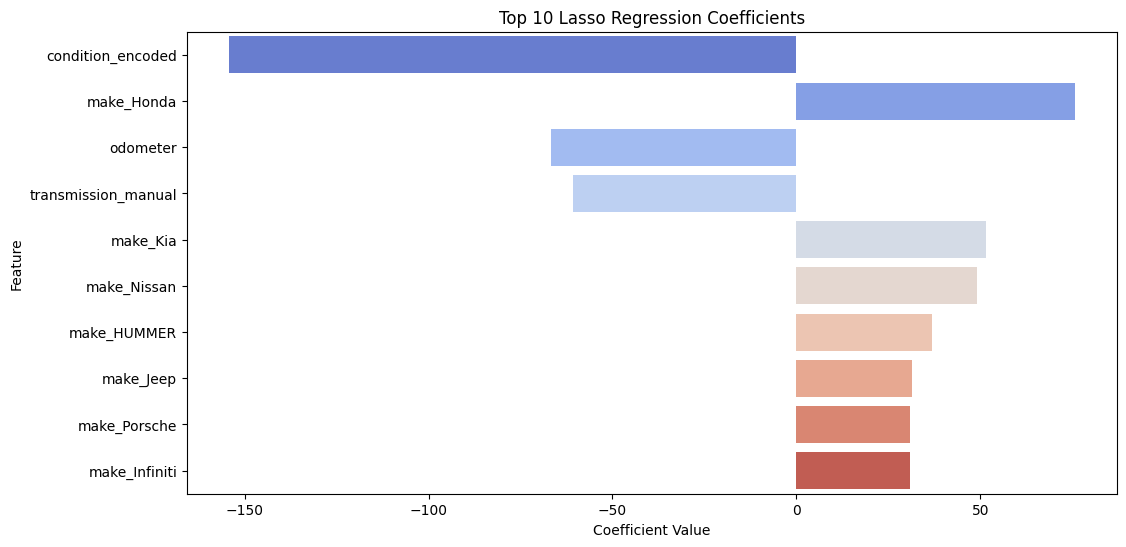

In [ ]:
# Get the coefficients
coef = lasso.coef_

# Create a DataFrame
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coef
})

# Sort by the abs
coef_df['abs_coef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False)

# Select the top 10 features
top_features = coef_df.head(10)

# Print the top 10 features and their coefficients
print("Top 10 LASSO Regression Coefficients:")
print(top_features[['Feature', 'Coefficient']])
print("")

plt.figure(figsize=(12, 6))
top_features = coef_df[coef_df['abs_coef'] > 0].head(10)
sns.barplot(data=top_features, x='Coefficient', y='Feature', hue='Feature', dodge=False, palette='coolwarm', legend=False)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Lasso Regression Coefficients')

# Show plot
plt.show()

In [ ]:
y_pred = lasso.predict(X_test_scaled)
residuals = y_test - y_pred

shapiro_stat, shapiro_p = shapiro(residuals)

# Print results
print(f'Shapiro-Wilk Test Statistic: {shapiro_stat}')
print(f'P-value: {shapiro_p}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Residuals
residuals = y_test - y_pred

# Residual Standard Error (RSE)
rse = np.sqrt(np.sum(residuals**2) / (len(y_test) - X_test.shape[1] - 1))
print(f"Residual Standard Error (RSE): {rse}")

Shapiro-Wilk Test Statistic: 0.993137259555343
P-value: 1.202769737252863e-10
Mean Squared Error (MSE): 1622434.0132327543
Residual Standard Error (RSE): 1288.1460380693436


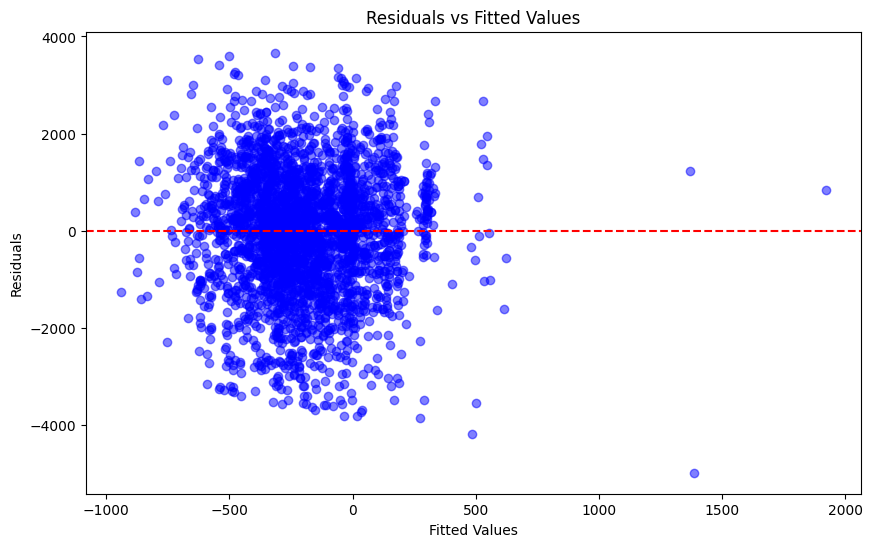

In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(y_pred, residuals, color = 'blue', alpha = 0.5)
plt.axhline(y = 0, color = 'red', linestyle = '--')
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

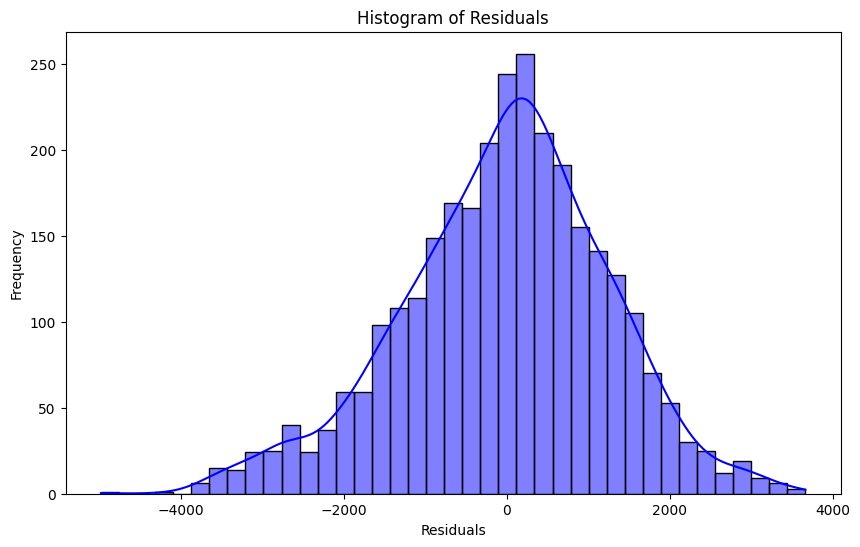

In [ ]:
plt.figure(figsize = (10,6))
sns.histplot(residuals, kde = True, color = 'blue')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

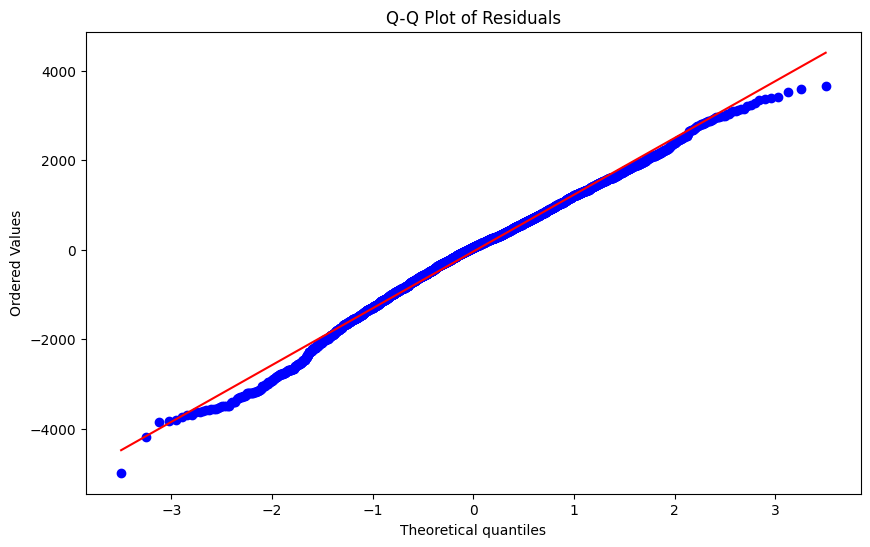

In [ ]:
plt.figure(figsize = (10,6))
stats.probplot(residuals, dist = "norm", plot = plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

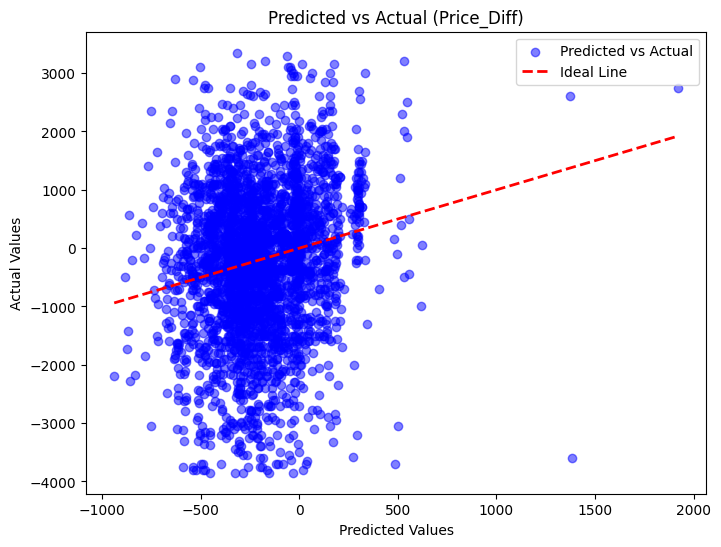

In [ ]:
# Predicted vs Actual Plot
plt.figure(figsize = (8, 6))
plt.scatter(y_pred, y_test, alpha = 0.5, color = 'blue', label = 'Predicted vs Actual')
plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], color = 'red', linestyle = '--', lw = 2, label = 'Ideal Line')
plt.title('Predicted vs Actual (Price_Diff)')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend()
plt.show()

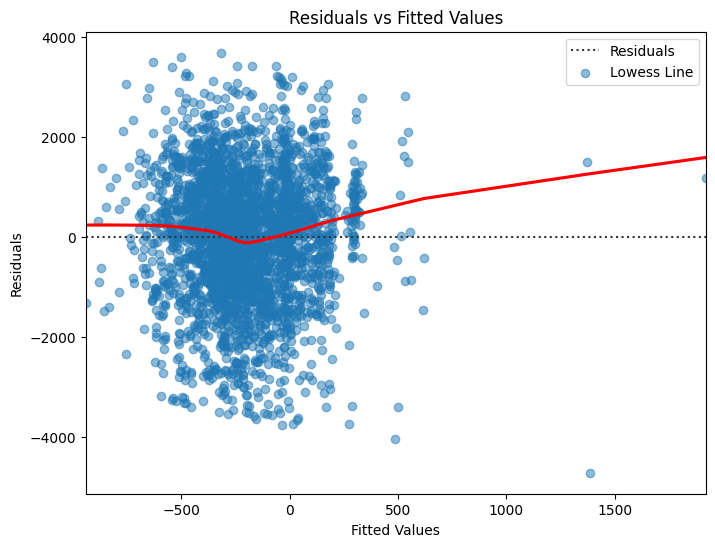

In [ ]:
# Residuals vs Fitted Plot
plt.figure(figsize = (8, 6))
sns.residplot(x = y_pred, y = y_test - y_pred, lowess = True, line_kws={'color': 'red'}, scatter_kws = {'alpha': 0.5})
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.legend(['Residuals', 'Lowess Line'], loc='upper right')
plt.show()

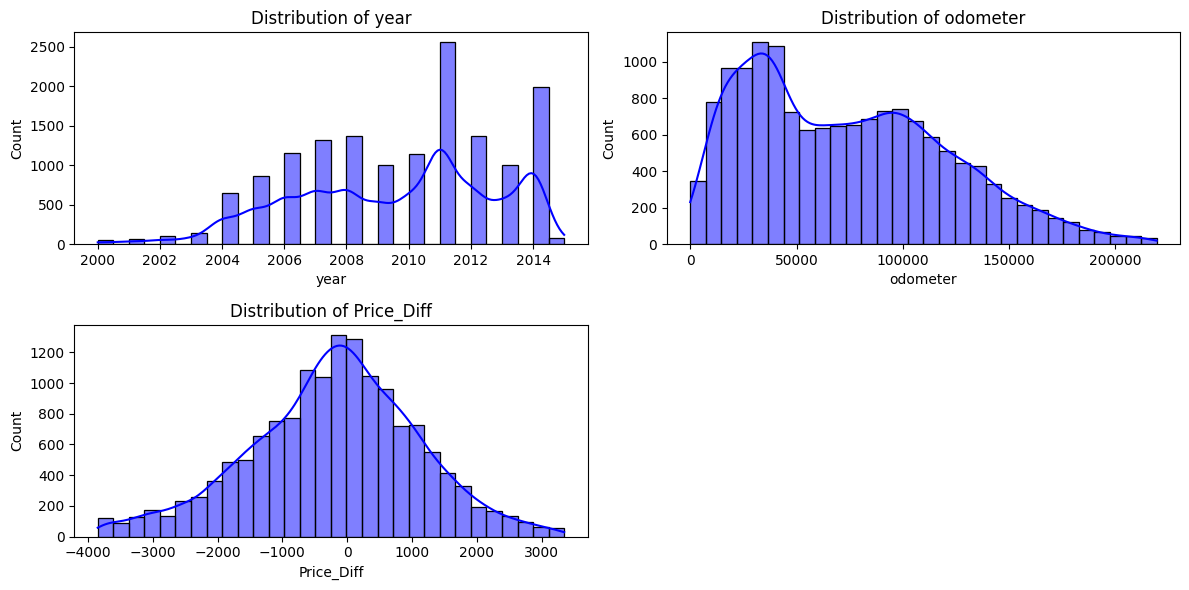

In [ ]:
# Univariate Analysis
plt.figure(figsize=(12, 6))
for i, col in enumerate(continuous_vars, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_filtered[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

<ipython-input-25-7f25669238b9>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.values, y=category_counts.index, palette='Set2')


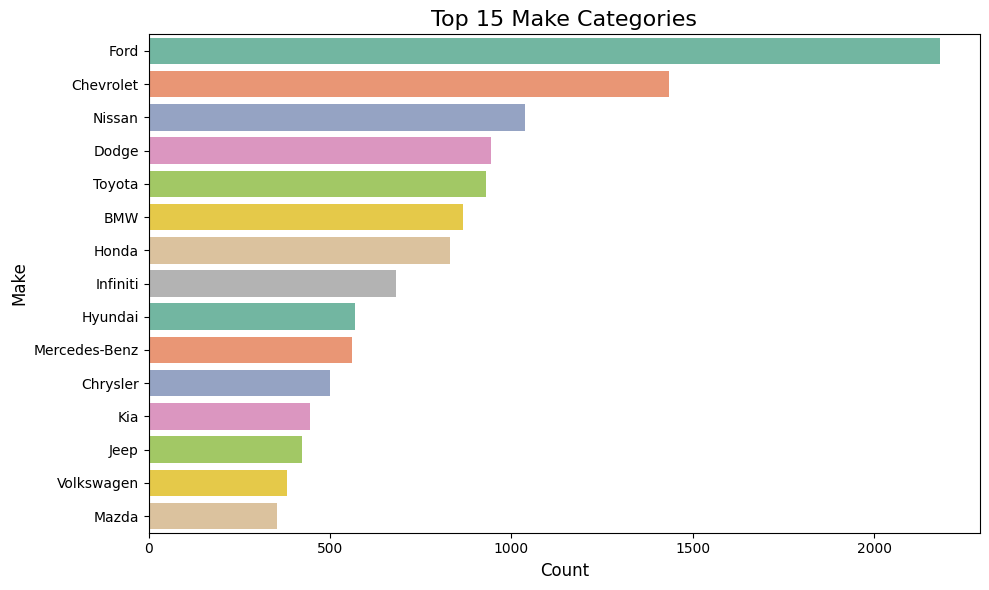

<ipython-input-25-7f25669238b9>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.values, y=category_counts.index, palette='Set2')


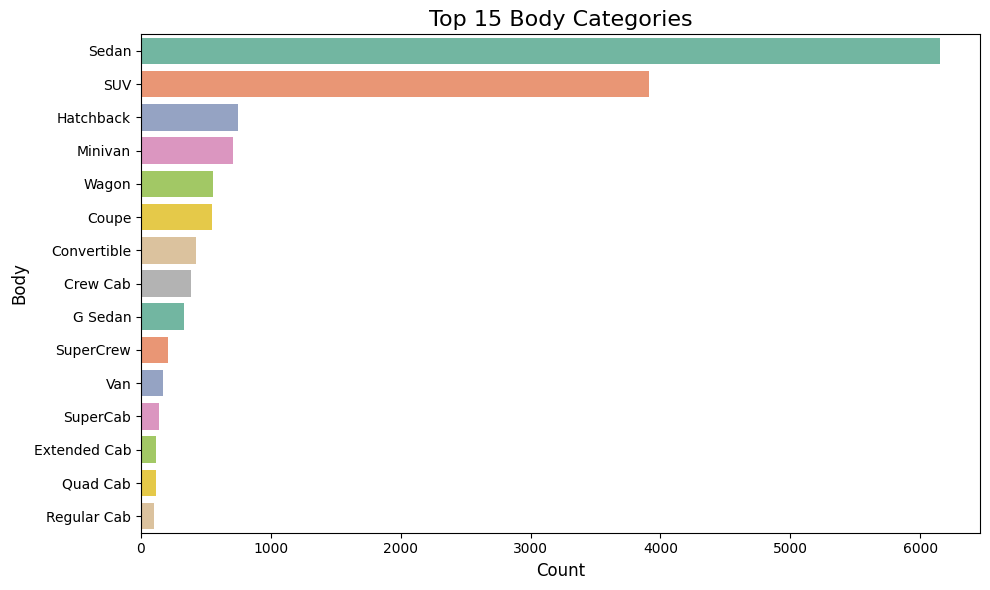

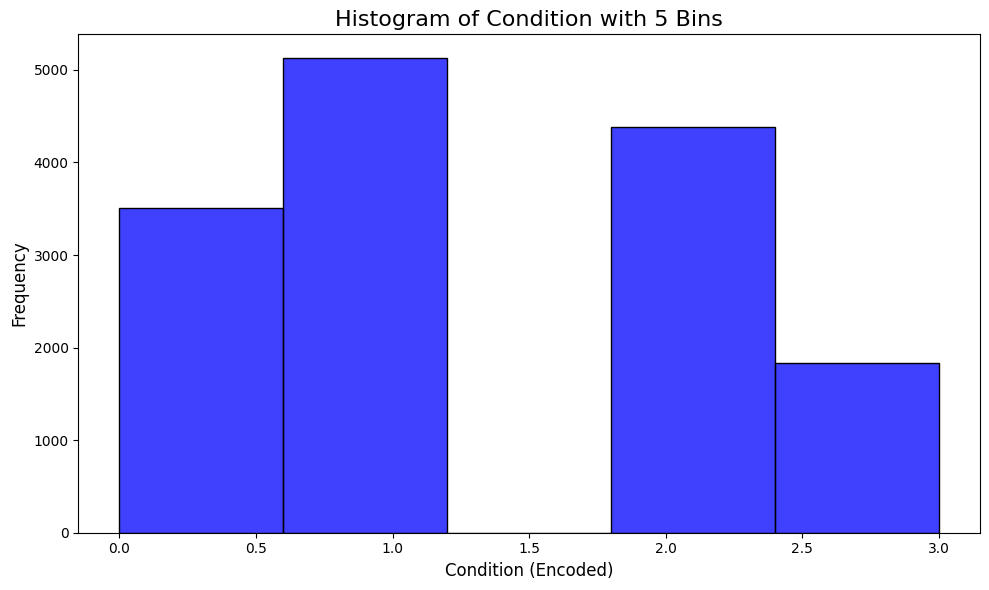

In [ ]:
# Function to plot a horizontal barplot for large categorical variables
def plot_large_categorical_distribution(df, column, top_n=15):
    # Count the occurrences of each category in the column
    category_counts = df[column].value_counts().head(top_n)

    # Create a horizontal bar plot for the top_n categories
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_counts.values, y=category_counts.index, palette='Set2')

    # Customize the plot
    plt.title(f'Top {top_n} {column.capitalize()} Categories', fontsize=16)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel(column.capitalize(), fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

# Plot for 'make' (top 15)
plot_large_categorical_distribution(df_filtered, 'make', top_n=15)

# Plot for 'body' (top 15)
plot_large_categorical_distribution(df_filtered, 'body', top_n=15)

# Histogram for 'condition' with 5 bins
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['condition_encoded'], bins=5, kde=False, color='blue')
plt.title('Histogram of Condition with 5 Bins', fontsize=16)
plt.xlabel('Condition (Encoded)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

<ipython-input-14-5298412ec197>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x='condition_category', order=['Poor', 'Fair', 'Good', 'Excellent'], palette='Blues')


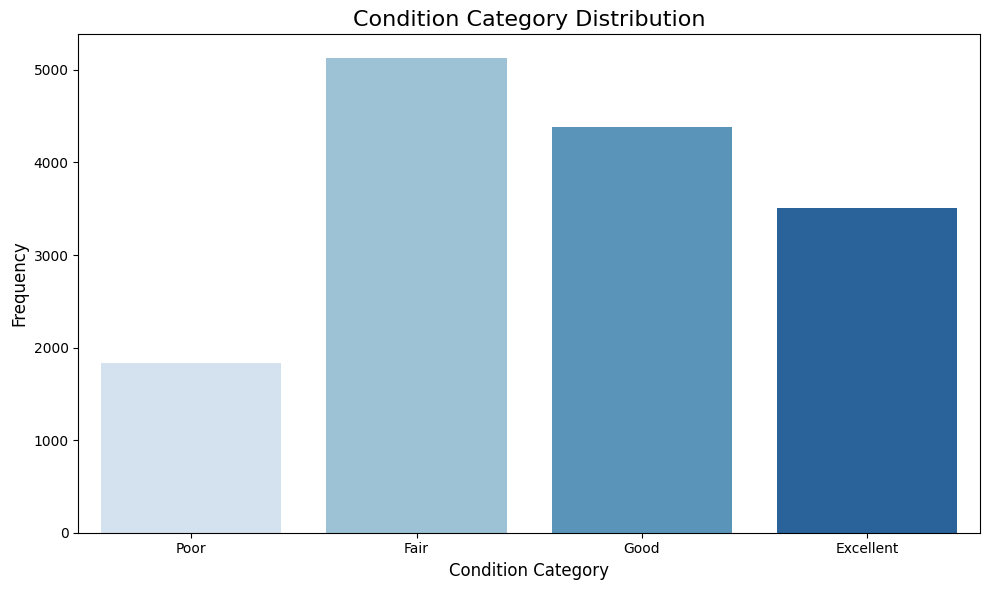

In [ ]:
# Plotting the histogram as a countplot for condition categories
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filtered, x='condition_category', order=['Poor', 'Fair', 'Good', 'Excellent'], palette='Blues')

plt.title('Condition Category Distribution', fontsize=16)
plt.xlabel('Condition Category', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

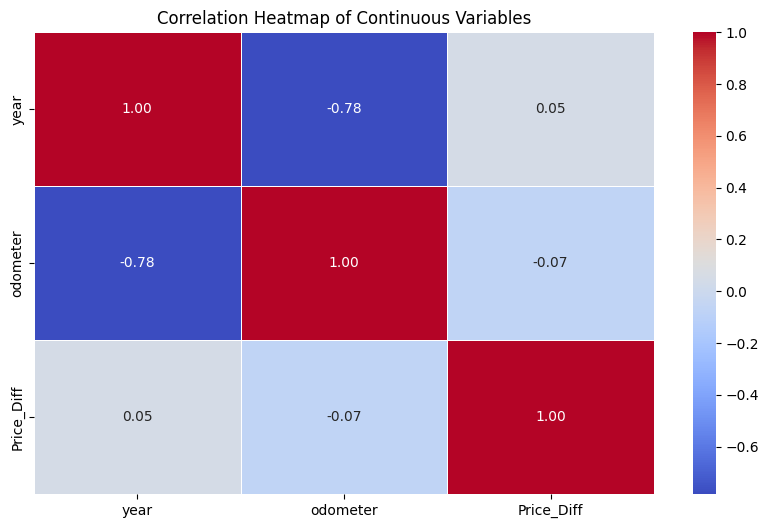

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
corr_matrix = df_filtered[continuous_vars].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Continuous Variables')
plt.show()

In [ ]:
# Export the cleaned and processed data to a CSV file for Tableau
file_path = "price_diff_analysis.csv"
df_ohe.to_csv(file_path, index=False)

print(f"File saved as {file_path}")

File saved as price_diff_analysis.csv
